In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import necessary libraries

from os.path import join
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K
#!pip install --upgrade tensorflow-model-optimization

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
import random
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix
from skimage import transform
from skimage import color, exposure, morphology, measure
from scipy.ndimage import median_filter
from skimage import feature
from skimage.filters import frangi
from skimage.measure import shannon_entropy
from skimage.morphology import binary_erosion, binary_dilation, disk
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [ ]:
# Set the path to your dataset
data_dir = "/content/drive/MyDrive/Kaggle_Dataset"

In [ ]:
# Create an ImageDataGenerator for data augmentation         Data Augmentation
# It generate more images using below parameters
dataset_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
augmented_data = dataset_datagen.flow_from_directory(data_dir,    # this is the target directory
                                      target_size=(224, 224),    # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')      # since we use binary_crossentropy loss, we need binary labels

Found 1482 images belonging to 4 classes.


In [ ]:
augmented_data.class_indices

{'bacterial_blight': 0, 'curl_virus': 1, 'fusarium_wilt': 2, 'healthy': 3}

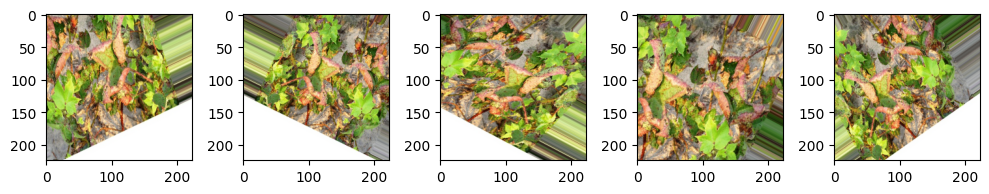

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

images = [augmented_data[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
classes = ["healthy", "bacterial_blight", "curl_virus", "fusarium_wilt"]
img_size = (224, 224)

def load_and_preprocess_data(data_dir, classes):
    data = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class {class_name}. Skipping.")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            if not os.path.exists(img_path):
                print(f"Warning: Image not found at {img_path}. Skipping.")
                continue

            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Failed to read image at {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(classes.index(class_name))

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

data, labels = load_and_preprocess_data(data_dir, classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Load the VGG16 model with pre-trained weights on ImageNet
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Create a new model on top of the VGG16 base
x_vgg16 = GlobalAveragePooling2D()(base_model_vgg.output)
x_vgg16 = Dense(64, activation='relu')(x_vgg16)
x_vgg16 = Dropout(0.1)(x_vgg16)
x_vgg16 = Dense(128, activation='relu')(x_vgg16)
x_vgg16 = Dropout(0.1)(x_vgg16)
x_vgg16 = Dense(256, activation='relu')(x_vgg16)
x_vgg16 = Dropout(0.25)(x_vgg16)
output_vgg16 = Dense(len(classes), activation='softmax')(x_vgg16)

vgg16_model = Model(inputs=base_model_vgg.input, outputs=output_vgg16)

In [ ]:
# Compile the VGG16 model
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_path12 = '/content/drive/MyDrive/training_models/vgg16_kaggle_predictor.h5'
checkpoint = ModelCheckpoint(model_path12, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Train the VGG16 model
history = vgg16_model.fit(X_train, y_train,
                          epochs=150,
                          verbose=1,
                          validation_split=0.1,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/150
34/34 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.4784
Epoch 1: val_accuracy improved from -inf to 0.55462, saving model to /content/drive/MyDrive/training_models/vgg16_kaggle_predictor.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 56s 830ms/step - loss: 1.1550 - accuracy: 0.4784 - val_loss: 1.2435 - val_accuracy: 0.5546
Epoch 2/150
34/34 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.7251
Epoch 2: val_accuracy improved from 0.55462 to 0.72269, saving model to /content/drive/MyDrive/training_models/vgg16_kaggle_predictor.h5
34/34 [==============================] - 16s 478ms/step - loss: 0.7009 - accuracy: 0.7251 - val_loss: 0.7235 - val_accuracy: 0.7227
Epoch 3/150
34/34 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8715
Epoch 3: val_accuracy improved from 0.72269 to 0.92437, saving model to /content/drive/MyDrive/training_models/vgg16_kaggle_predictor.h5
34/34 [==============================] - 17s 511ms/step - loss: 0.4115 - accuracy: 0.8715 - val_loss: 0.2158 - val_accuracy: 0.9244
Epoch 4/150
34/34 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.9081
Epoch 4: val_accuracy did not improve from 0.

In [ ]:
# Evaluate the ResNet50 model
print("[INFO] Calculating model accuracy")
scores = vgg16_model.evaluate(X_train, y_train)
print(f"Training Accuracy: {round(scores[1], 4) * 100}%")

print("[INFO] Calculating model accuracy")
scores = vgg16_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(scores[1], 4) * 100}%")

[INFO] Calculating model accuracy
38/38 [==============================] - 6s 162ms/step - loss: 2.8427e-04 - accuracy: 1.0000
Training Accuracy: 100.0%
[INFO] Calculating model accuracy
10/10 [==============================] - 4s 429ms/step - loss: 0.1509 - accuracy: 0.9764
Test Accuracy: 97.64%


In [ ]:
vgg_predictions_test = vgg16_model.predict(X_test)
vgg_predictions_test = np.argmax(vgg_predictions_test, axis=1)

10/10 [==============================] - 1s 136ms/step


In [ ]:
vgg_eval = vgg16_model.evaluate(X_test, y_test)
vgg_accuracy = vgg_eval

10/10 [==============================] - 1s 128ms/step - loss: 0.1509 - accuracy: 0.9764


In [ ]:
vgg_eval

[0.15085652470588684, 0.9764309525489807]

In [ ]:
import seaborn as sns
class_labels = ["bacterial blight", "fusarium wilt", "curl virus", "healthy"]
def evaluate_model(vgg_predictions_test, y_test, model_name):
    accuracy = accuracy_score(y_test, vgg_predictions_test)
    precision = precision_score(y_test, vgg_predictions_test, average='weighted')
    recall = recall_score(y_test, vgg_predictions_test, average='weighted')
    f1 = f1_score(y_test, vgg_predictions_test, average='weighted')
    conf_matrix = confusion_matrix(y_test, vgg_predictions_test)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_report = classification_report(y_test, vgg_predictions_test, target_names=class_labels)
    print('Classification Report:')
    print(class_report)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

      # Return the metrics
    return accuracy, precision, recall, f1

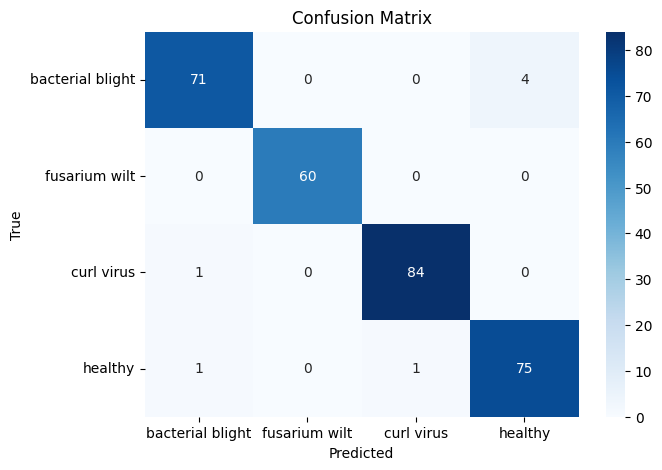

Classification Report:
                  precision    recall  f1-score   support

bacterial blight       0.97      0.95      0.96        75
   fusarium wilt       1.00      1.00      1.00        60
      curl virus       0.99      0.99      0.99        85
         healthy       0.95      0.97      0.96        77

        accuracy                           0.98       297
       macro avg       0.98      0.98      0.98       297
    weighted avg       0.98      0.98      0.98       297

Results for VGG16:
Accuracy: 0.9764309764309764
Precision: 0.976587445462077
Recall: 0.9764309764309764
F1 Score: 0.9764239764239764


In [ ]:
accuracy, precision, recall, f1 = evaluate_model(vgg_predictions_test, y_test, "VGG16")

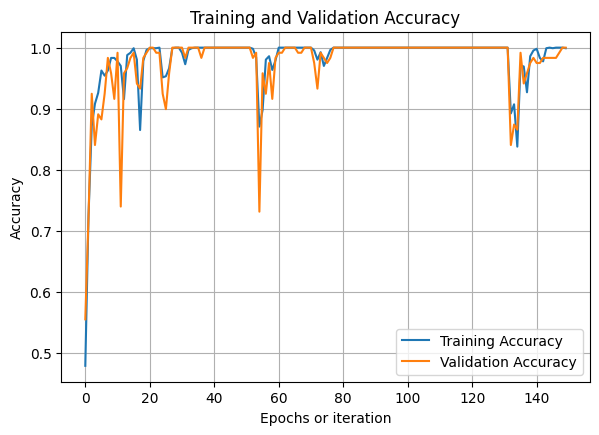

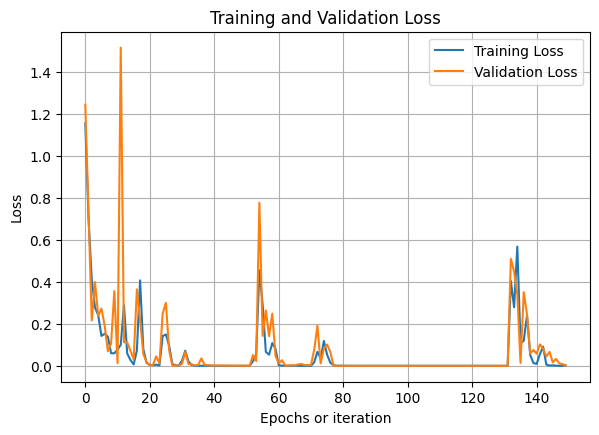

In [ ]:
#plt.figure(figsize=(10, 5))
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
# (2,2) means Width and Height of Diagram
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs or iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs or iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()